# Predictive Quality Control for Manufacturing

## Importing Required Libraries

In [1276]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA

from scipy.stats import gaussian_kde
import os

## Data Preprocessing

In [1277]:
def preprocess_data(file_path):
    # Load dataset
    data = pd.read_csv(file_path)

    # Check for non-numeric columns and attempt encoding
    for column in data.select_dtypes(include=['object']).columns:
        # If the column is categorical, encode it
        if data[column].dtype == 'object':
            # Option 1: Label encoding (if there are few unique values)
            label_encoder = LabelEncoder()
            data[column] = label_encoder.fit_transform(data[column])
    
    # Separate features (X) and target (y)
    X = data.drop(columns=['y1', 'y2'])  # Assuming 'y1' and 'y2' are the target columns
    y = data[['y1', 'y2']]  # Adjust this as needed
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # Standardize the input data (features)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, data

In [1278]:
def preprocess_data_From_Frame(data, key):
    

    # Check for non-numeric columns and attempt encoding
    for column in data.select_dtypes(include=['object']).columns:
        # If the column is categorical, encode it
        if data[column].dtype == 'object':
            # Option 1: Label encoding (if there are few unique values)
            label_encoder = LabelEncoder()
            data[column] = label_encoder.fit_transform(data[column])
    
    # Separate features (X) and target (y)
    X = data.drop(columns=[key])  
    y = data[[key]]  
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # Standardize the input data (features)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, data

## Exploratory Data Analysis (EDA)

In [1279]:
def perform_eda(data):
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Heatmap')
    plt.show()

    for col in ['u1', 'u2', 'u3', 'u4', 'u5']:
        try: 
            sns.scatterplot(x=data[col], y=data['y1'])
            plt.title(f'{col} vs Tension (T1)')
            plt.xlabel(col)
            plt.ylabel('Tension T1')
            plt.show()

            sns.scatterplot(x=data[col], y=data['y2'])
            plt.title(f'{col} vs Tension (T3)')
            plt.xlabel(col)
            plt.ylabel('Tension T3')
            plt.show()
        except:
            pass

## Predictive Modeling

In [1280]:
def train_model(X_train, y_train):
    model = linear_model.Ridge(alpha=0.5)#LinearRegression()
    model.fit(X_train, y_train)
    joblib.dump(model, 'tension_prediction_model.pkl')
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
    return mse, r2, y_pred

Classification

In [1281]:
def classify_data(data: pd.DataFrame, key, threshold, threshold2):
    classes = []
    for x in range(len(data['u1'])):
        if data[key][x] > threshold or data['y2'][x] > threshold2:
            classes.append(1)
        else:
            classes.append(0)
    classi = pd.Series(classes)
    data = data.assign(classi=classi.values)
    data = data.drop(columns=['y1', 'y2'])
    return data

def train_classifier(x_train, y_train):
    classifier = SVC(kernel='linear')
    classifier.fit(x_train, y_train.values.ravel())
    return classifier

def evaluate_classifier(classifier, x_test, y_test):
    y_pred = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, y_pred

## Quality Control Integration

In [1282]:
def plot_spc_chart(y_test, threshold, title):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label='Actual T1', marker='o')
    plt.axhline(y_test.mean(), color='r', linestyle='dashed', label='Mean T1')
    plt.axhline(threshold, color='b', linestyle='solid', label='Upper Control Line')
    plt.axhline(-threshold, color='b', linestyle='solid', label='Lower Control Line')


    plt.xlabel('Sample Index')
    plt.ylabel('Tension')
    plt.legend()
    plt.title('Statistical Process Control Chart for ' + title)
    plt.show()

# Alarms

In [1283]:
def trigger_alarm(y_value, threshold):
    alarms = y_value > threshold
    if np.any(alarms):
        print("Alarm triggered! Process values exceed the threshold.")
    else:
        print("No alarm. All predicted values are within the threshold.")

## Six Sigma Framework

In [1284]:
def calculate_dpmk(y_actual, thresholdy1, thresholdy2):
    # Calculating Defects Per Million Opportunities (DPMO)
    defects = 0
    for x in range(len(y_actual)):
        if (np.abs(y_actual[x, 0]) > thresholdy1): # or (np.abs(y_actual[x, 1]) > thresholdy2):
            defects = defects + 1
    #defects_t3 = np.sum(np.abs(y_actual[:, 1]) > thresholdy2)
    
    opportunities = len(y_actual)
    #defects = defects_t1 + defects_t3
    
    return (defects / opportunities) * 1_000_000

def calculate_dpmk_model(y_actual, y_predicted, thresholdy1):
    # Calculating Defects Per Million Opportunities (DPMO)
    defects_t1 = np.sum(np.abs(y_actual[:, 0] - y_predicted) > thresholdy1)
    
    opportunities = len(y_actual) # T1 and T3
    defects = defects_t1
    
    return (defects / opportunities) * 1_000_000

def calculate_cpk(data, usl, lsl):
    # Calculating Process Capability Index (Cpk)
    mean = data.mean()
    std_dev = data.std()
    cpu = (usl - mean) / (1.5 * std_dev)
    cpl = (mean - lsl) / (1.5 * std_dev)
    
    return min(cpu, cpl)

In [1285]:
def findOutliers(dataframe, threshold, key) -> pd.DataFrame:
    if key not in dataframe.columns:
        raise ValueError("The DataFrame does not contain a 'y1' column.")

    outliers = dataframe[(dataframe[key] > threshold)] #| (dataframe[key] < -1*threshold) Only positive for testing
        
    return outliers

In [1286]:
def onlyPositive(outliers) -> pd.DataFrame:

    outliers = outliers[(outliers['u5'] > 0)]
    outliers = outliers[(outliers['u2'] > 0)]
    outliers = outliers[(outliers['u4'] < 0)]
    
    return outliers

In [1287]:
def onlyNegative(outliers) -> pd.DataFrame:

    outliers = outliers[(outliers['u5'] < 0)]
    
    return outliers

In [1288]:
def plot_distribution(data, column, title):
    plt.figure(figsize=(12, 6))
    
    # Plot histogram with more bins
    sns.histplot(data[column], kde=False, bins=50, color='blue', label=f'{column} Histogram')
    
    plt.title(f'Distribution of {title}')
    plt.xlabel(f'{column}')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [1289]:
def plot_kde_manual(data, column):
    x_values = np.linspace(data[column].min(), data[column].max(), 100)
    kde = gaussian_kde(data[column])  # Compute KDE
    y_values = kde(x_values)

    plt.figure(figsize=(8, 4))
    plt.hist(data[column], bins=30, density=True, alpha=0.5, color='blue', edgecolor='black', label='Histogram')
    plt.plot(x_values, y_values, color='red', label='KDE')
    
    # Axis Labels
    plt.xlabel("Value")  
    plt.ylabel("Density")
    plt.title(f'KDE of {column}')
    plt.legend()
    plt.show()

## Running the Workflow

Upper Specification Limit = 1.5003000896336678


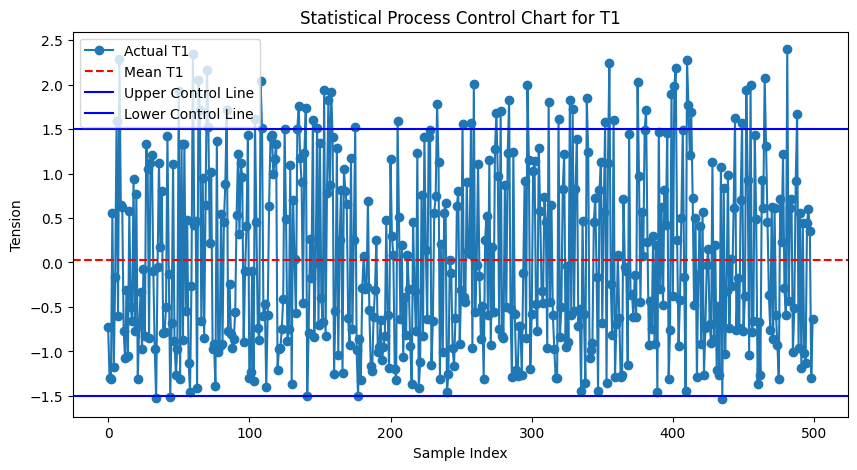

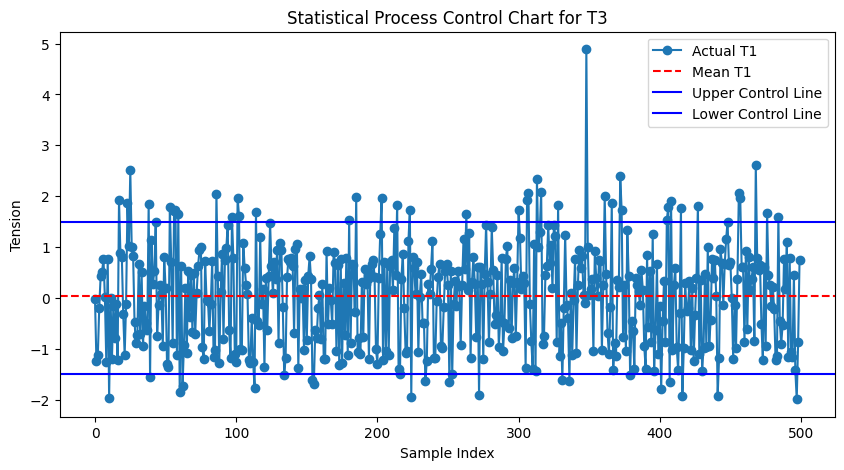

Alarm triggered! Process values exceed the threshold.
Defects Per Million Opportunities (DPMO): 108800.00
Process Capability Index (Cpk): 1.00


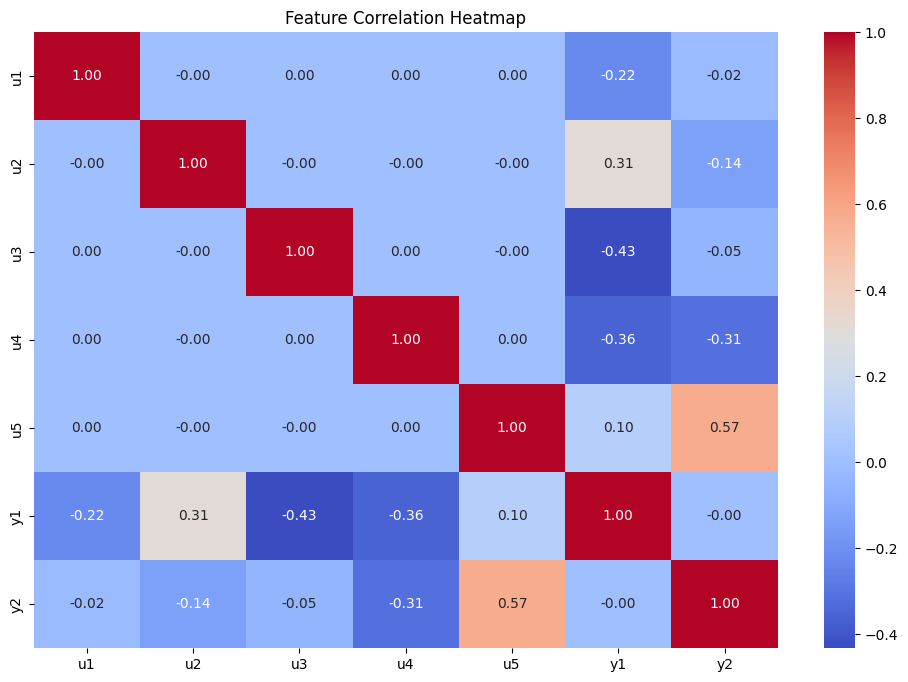

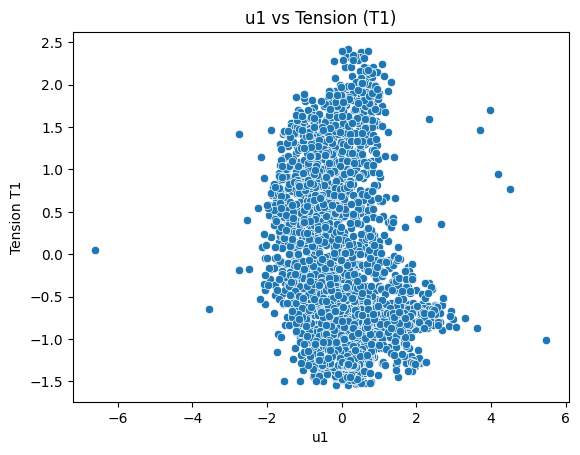

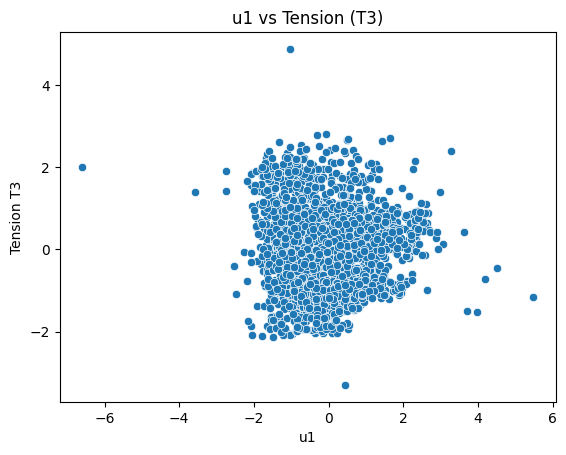

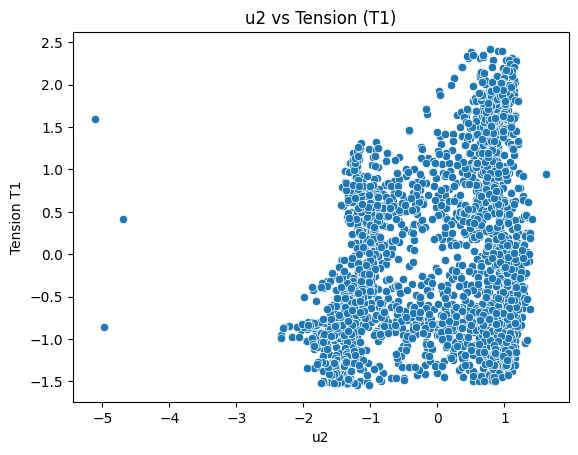

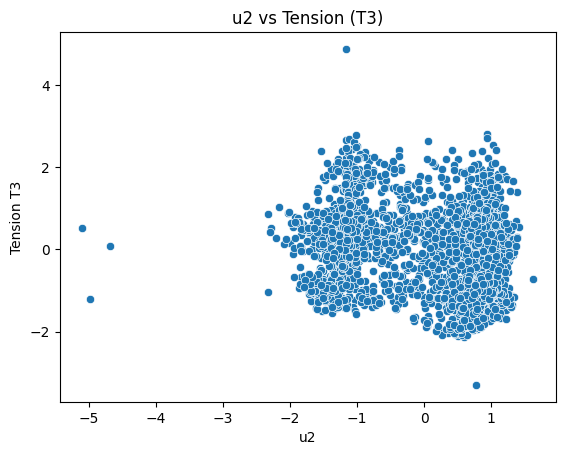

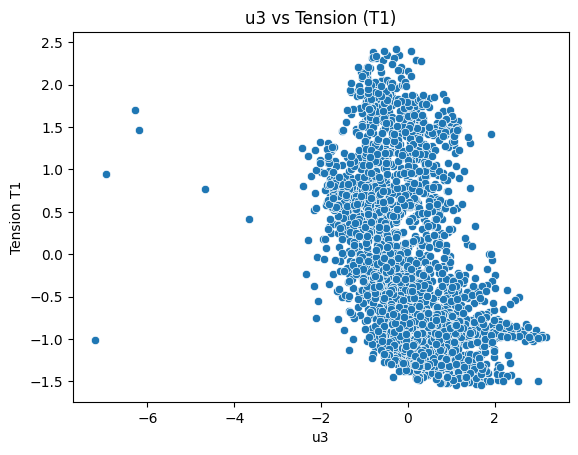

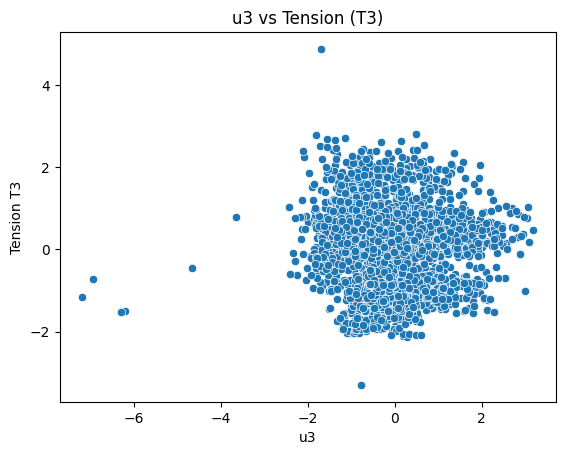

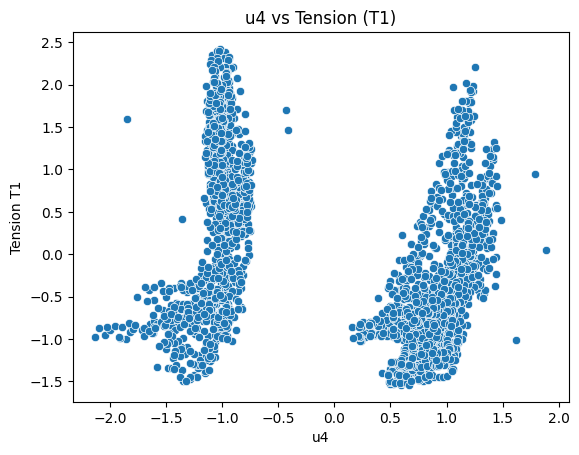

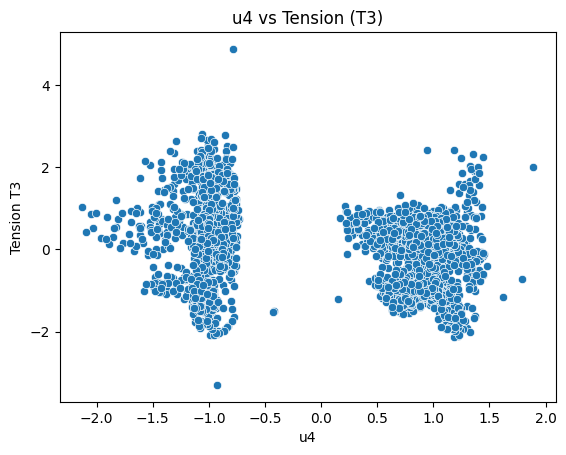

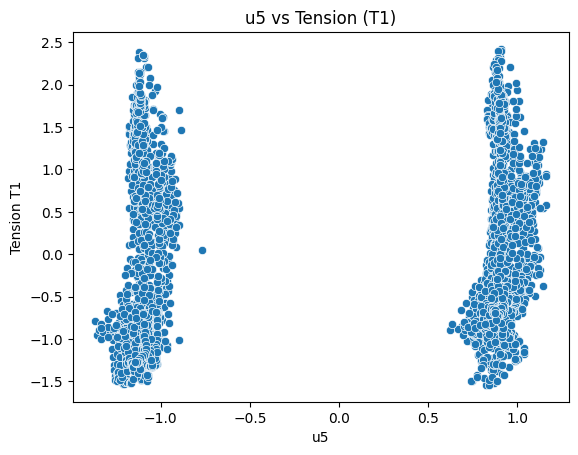

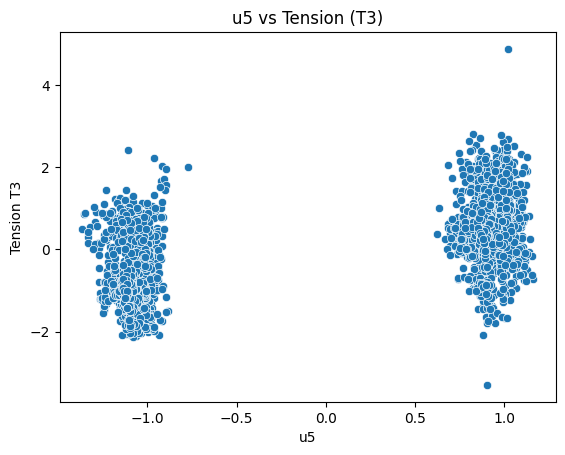

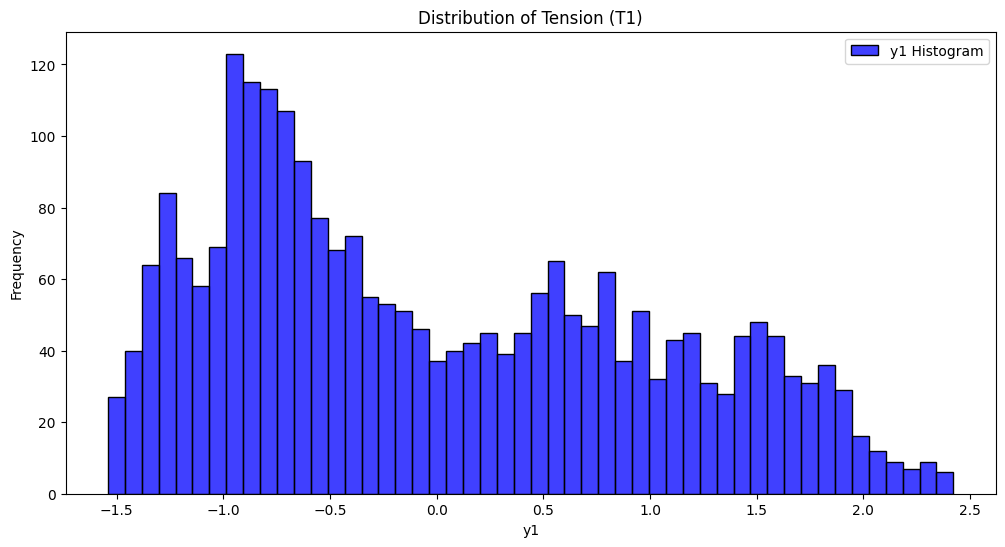

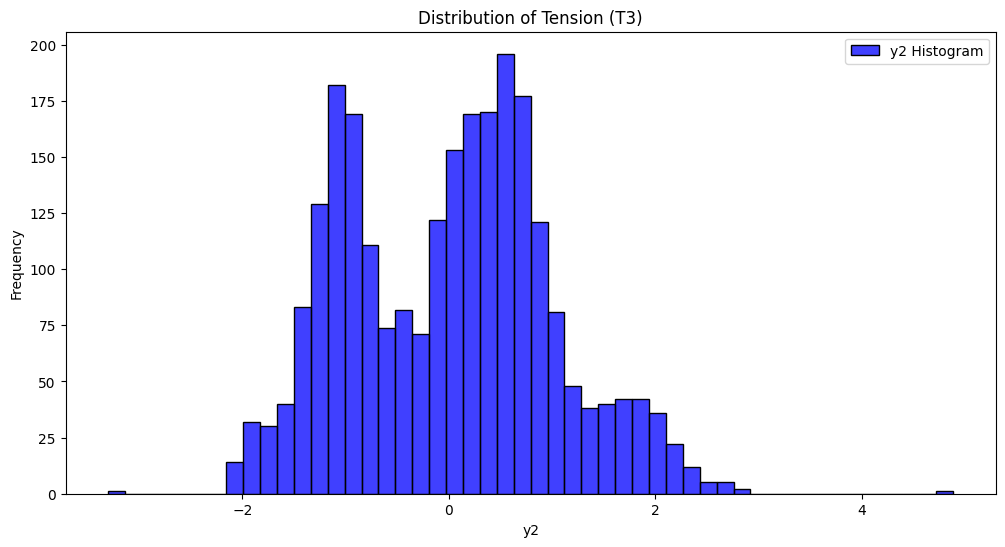

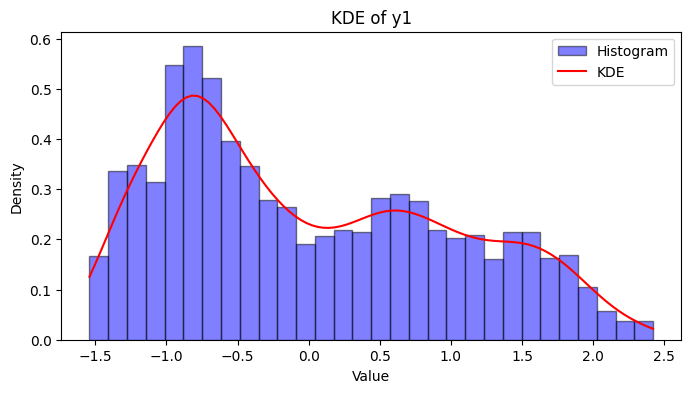

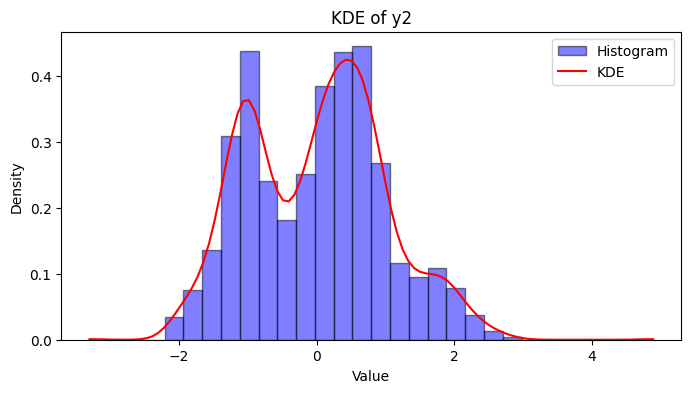

Initial Model
Model Performance: MSE = 0.5480, R² Score = 0.4690
Focus on Out of Spec Parts


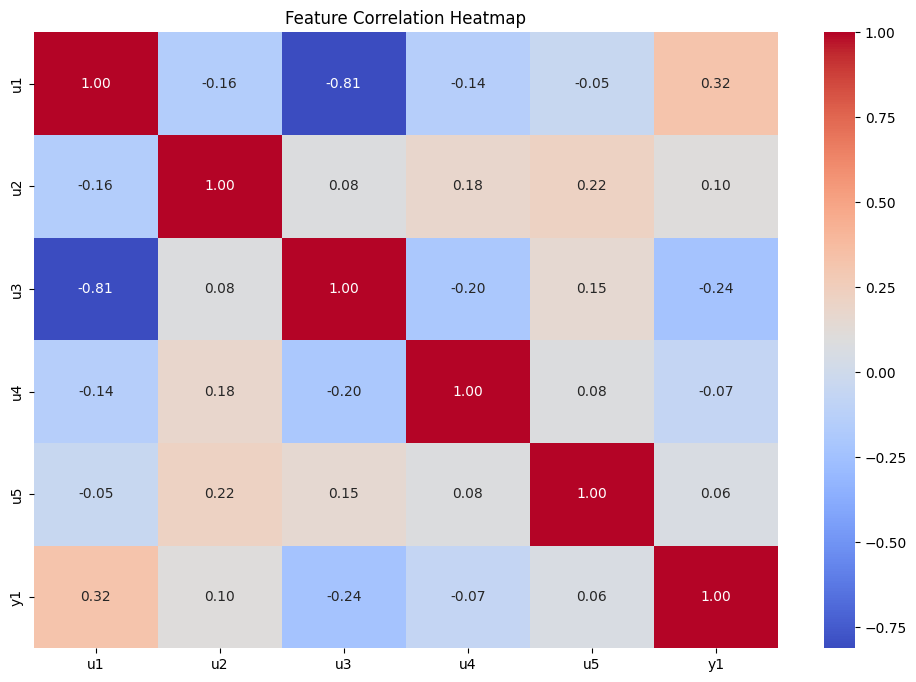

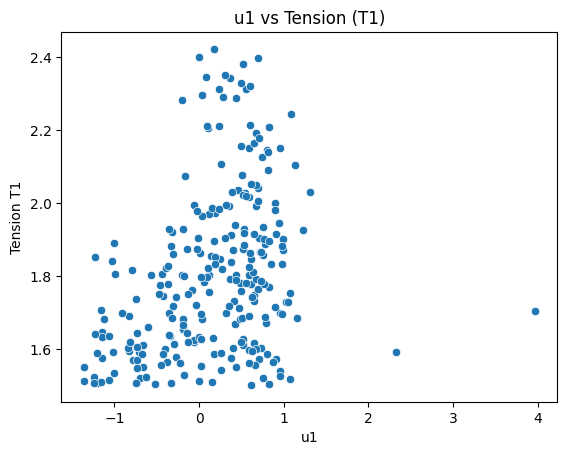

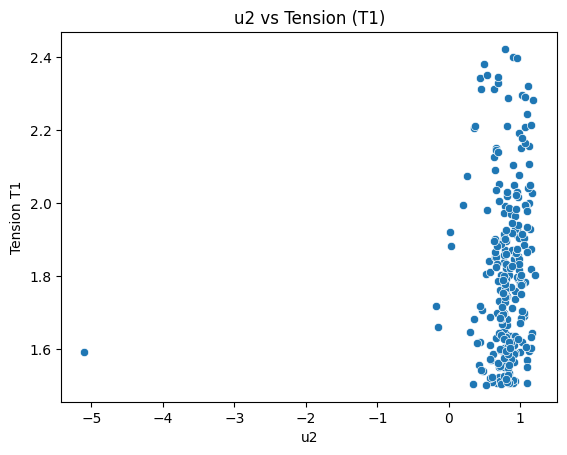

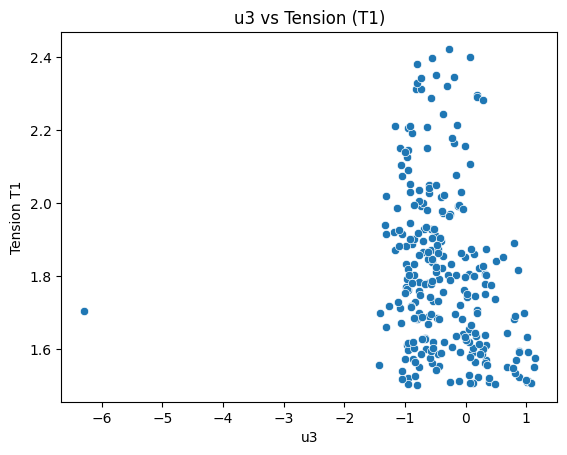

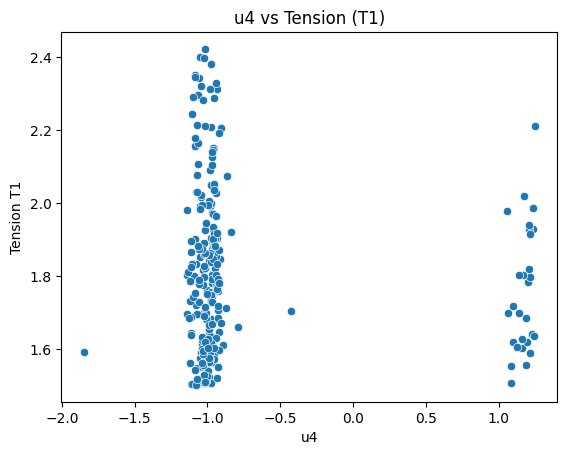

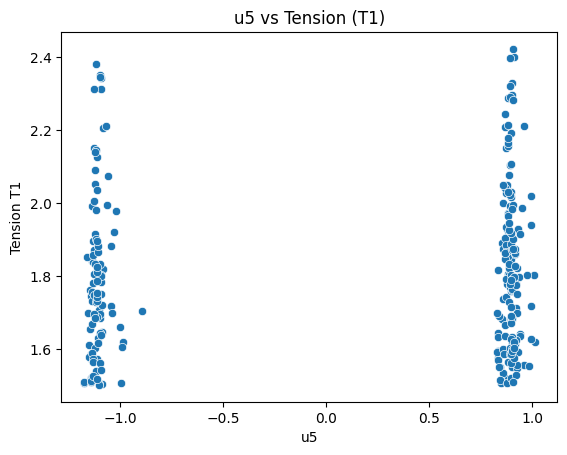

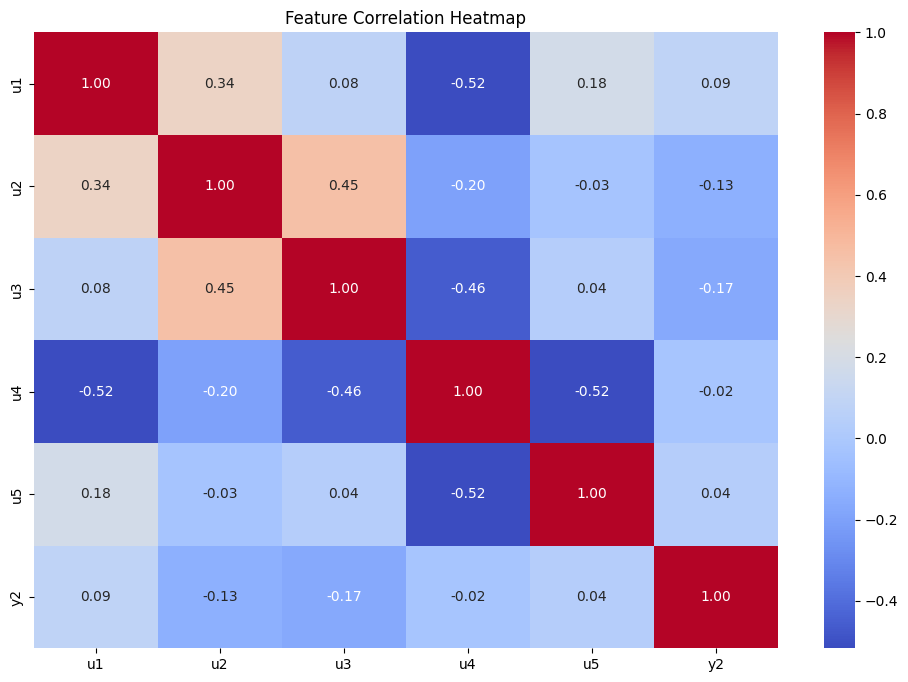

Consider Only Positive U5


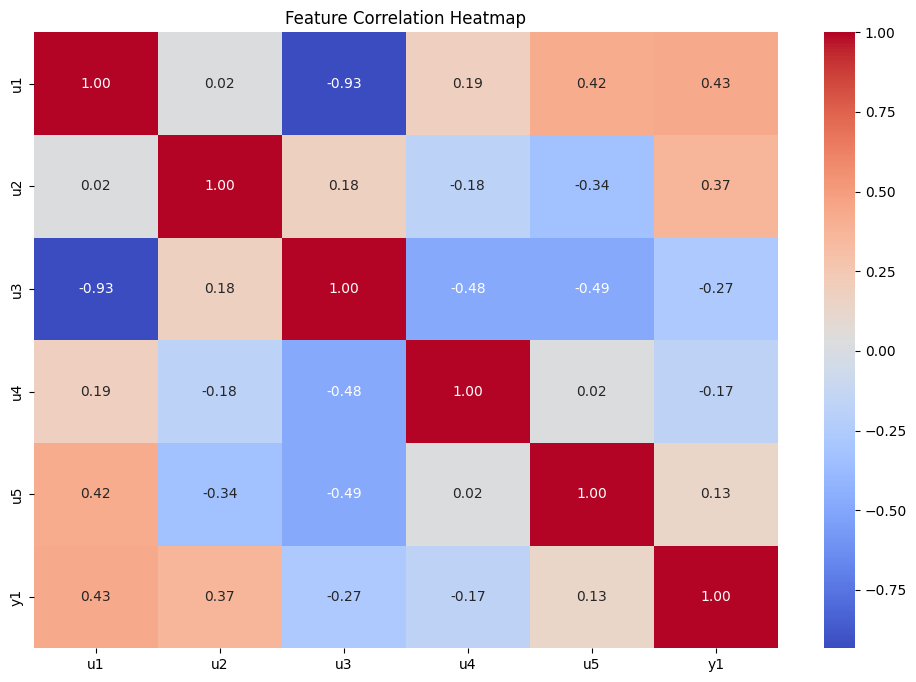

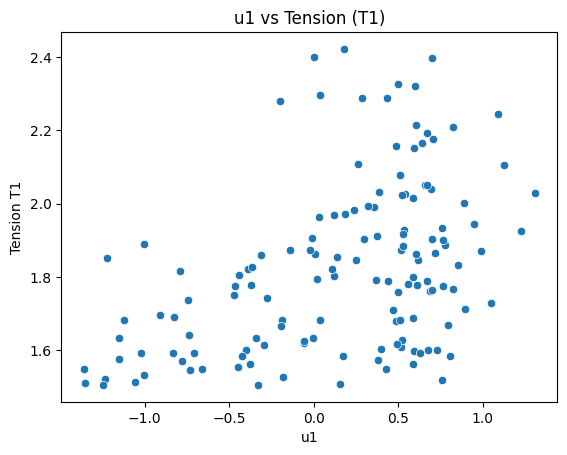

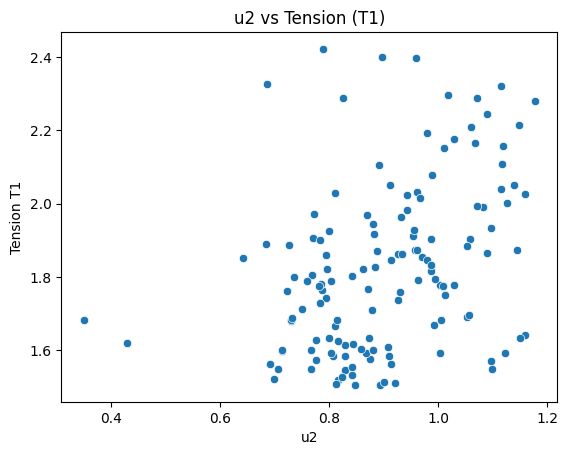

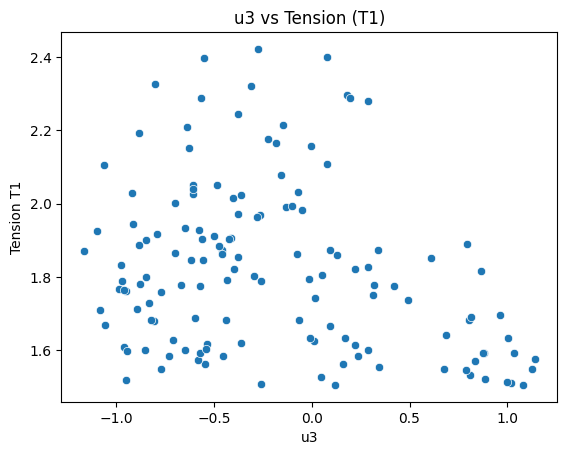

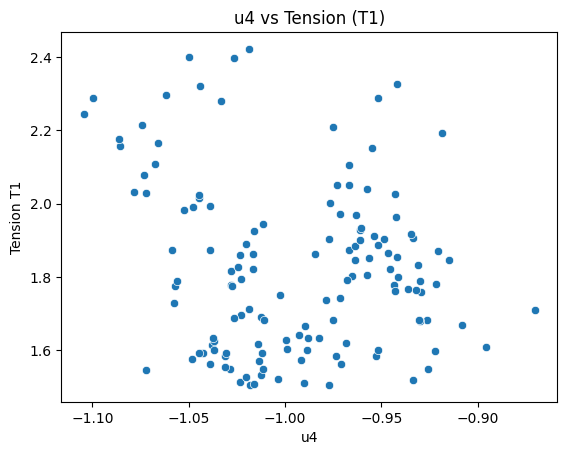

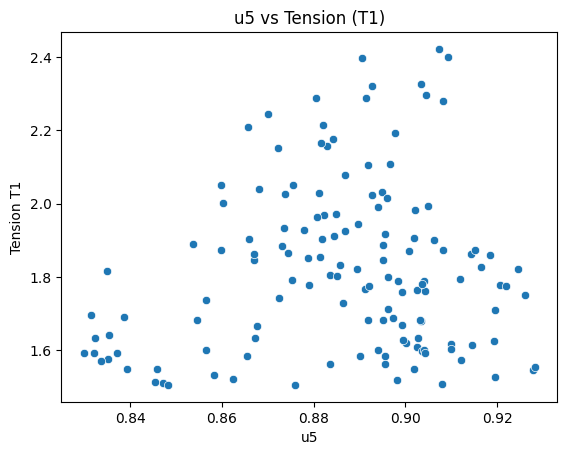

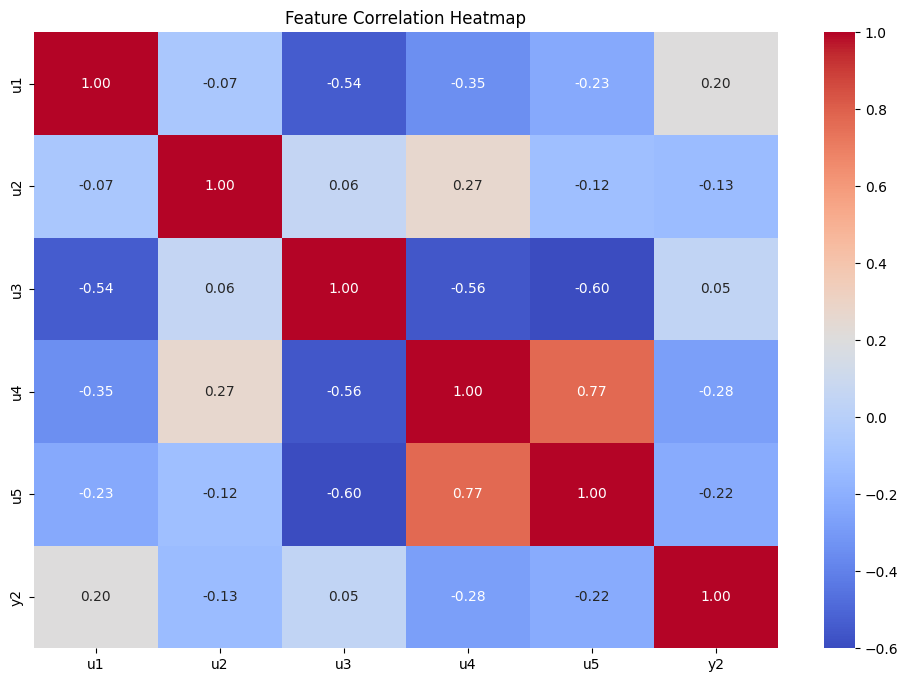

Negative U5


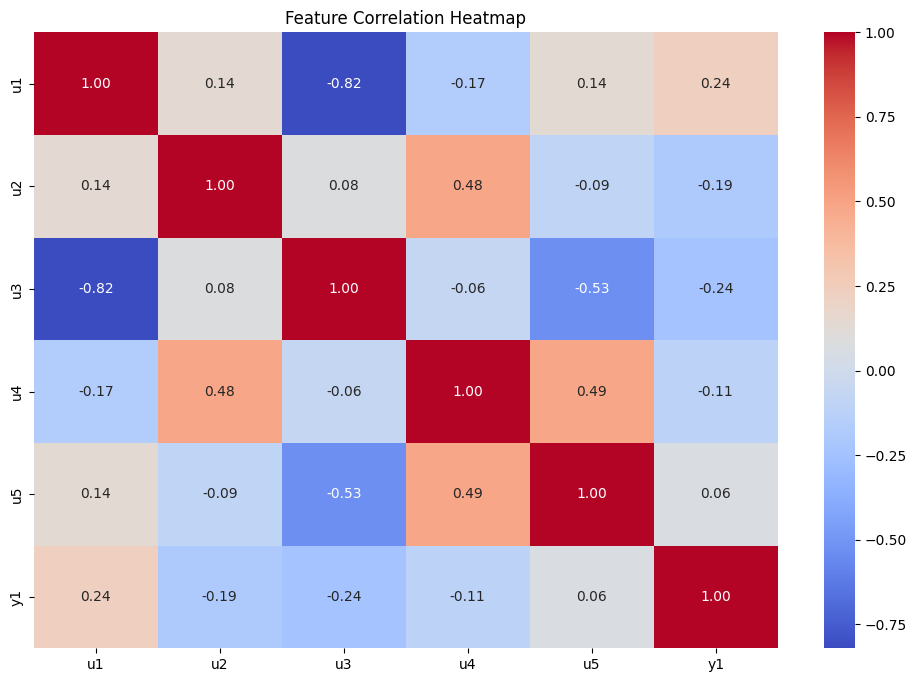

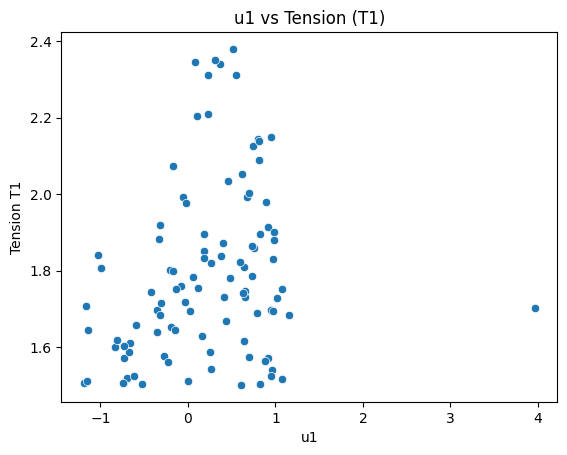

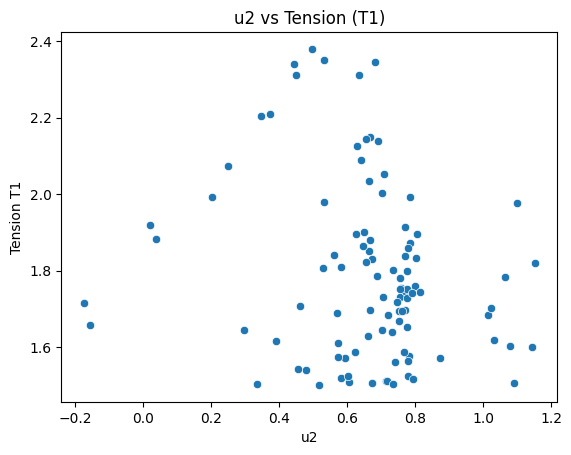

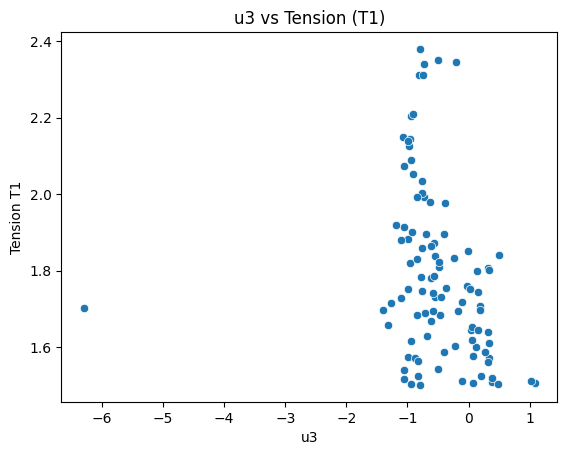

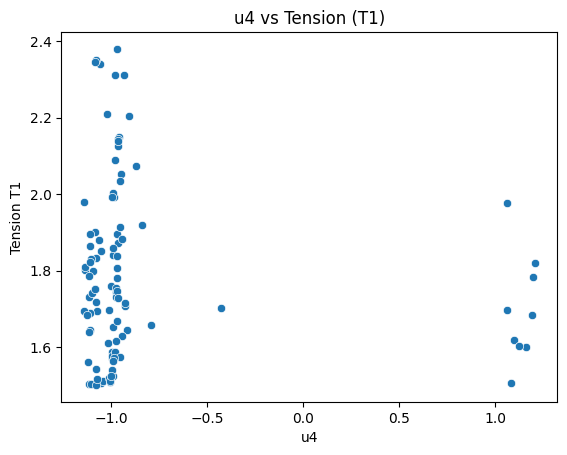

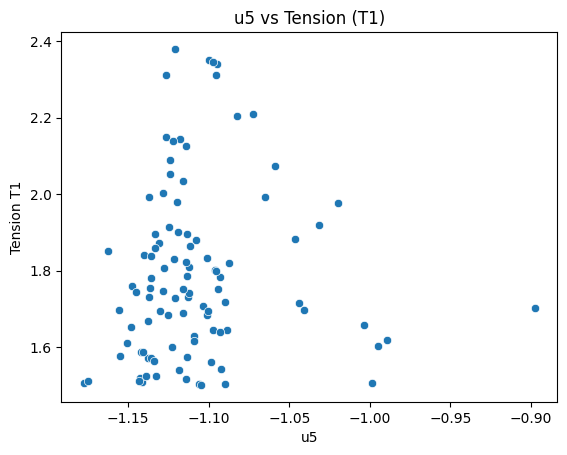

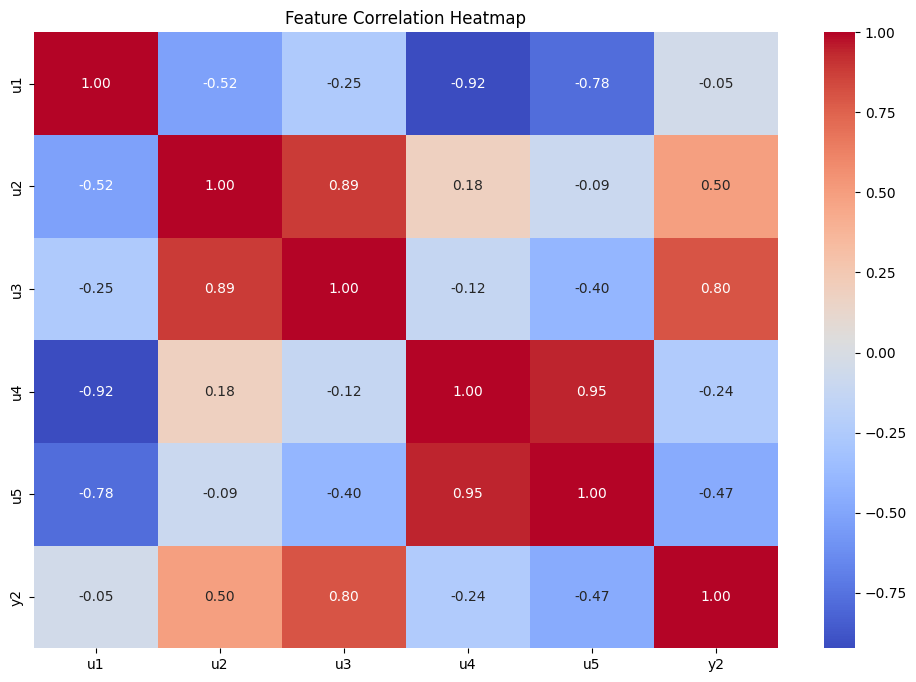

Model for Out of Spec
Model Performance: MSE = 0.0465, R² Score = 0.1294
------
Classification Model
Accuracy: 0.82
Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90       410
           1       0.00      0.00      0.00        90

    accuracy                           0.82       500
   macro avg       0.41      0.50      0.45       500
weighted avg       0.67      0.82      0.74       500

Cross-validation Accuracy: 0.82 (+/- 0.00
Accuracy Optimized: 0.82
Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90      1026
           1       1.00      0.01      0.02       224

    accuracy                           0.82      1250
   macro avg       0.91      0.50      0.46      1250
weighted avg       0.85      0.82      0.74      1250

Cross-validation Accuracy: 0.82 (+/- 0.00
Principal Components:
         PC1       PC2
0 -0.080592 -1.239835
1  0.0

In [1290]:
# Load and preprocess the dataset
file_path = 'processData.csv'  # Update this with the actual dataset path
X_train, X_test, y_train, y_test, data = preprocess_data(file_path)

#Threshold
thresholdy1 = data['y1'].mean() + 1.5*data['y1'].std()
print("Upper Specification Limit = " + str(thresholdy1))
thresholdy2 = data['y2'].mean() + 1.5*data['y2'].std() 

# Quality Control Integration
plot_spc_chart(y_test['y1'], thresholdy1, 'T1')
plot_spc_chart(y_test['y2'], thresholdy2, 'T3')

trigger_alarm(data['y1'].values, threshold=thresholdy1)  # Set the threshold for alarms

# Six Sigma Analysis Of Data
dpmk = calculate_dpmk(data.get(['y1', 'y2']).values, thresholdy1, thresholdy2)
cpk = calculate_cpk(data['y1'].values, usl=thresholdy1, lsl=-thresholdy1)  # Example upper and lower spec limits
print(f'Defects Per Million Opportunities (DPMO): {dpmk:.2f}')
print(f'Process Capability Index (Cpk): {cpk:.2f}')


# Perform EDA
perform_eda(data)

# Plot distribution for Tension T1 (y1) and Tension T3 (y2)
plot_distribution(data, 'y1', 'Tension (T1)')
plot_distribution(data, 'y2', 'Tension (T3)')

# Plot KDE for Tension T1 (y1) and Tension T3 (y2)
plot_kde_manual(data, 'y1')
plot_kde_manual(data, 'y2')

# Train the predictive model
model = train_model(X_train, y_train)

# Evaluate the model
print('Initial Model')
mse, r2, y_pred = evaluate_model(model, X_test, y_test)
print(f'Model Performance: MSE = {mse:.4f}, R² Score = {r2:.4f}')

#Gather Outliers for new model
print('Focus on Out of Spec Parts')
outliersy1 = findOutliers(data, thresholdy1, 'y1')
outliersy1 = outliersy1.drop(columns='y2', axis=1)
outliersy2 = findOutliers(data, thresholdy2, 'y2')
outliersy2 = outliersy2.drop(columns='y1',axis=1)

#plot outliers to visualize
perform_eda(outliersy1)
perform_eda(outliersy2)

#Try Outliers only Positive U5
print('Consider Only Positive U5')
perform_eda(onlyPositive(outliersy1))
perform_eda(onlyPositive(outliersy2))

#Try Outliers only Negative U5
print('Negative U5')
perform_eda(onlyNegative(outliersy1))
perform_eda(onlyNegative(outliersy2))

#Model for Outliers 
print('Model for Out of Spec')
X_train2, X_test2, y_train2, y_test2, data2 = preprocess_data_From_Frame(onlyPositive(outliersy1), 'y1')
model2 = train_model(X_train2, y_train2)
mse2, r22, y_pred2 = evaluate_model(model2, X_test2, y_test2)
print(f'Model Performance: MSE = {mse2:.4f}, R² Score = {r22:.4f}')
print('------')


# Compute defects count
defects = np.sum((y_test.values > thresholdy1) | (y_test.values < -thresholdy1))
total_opportunities = len(y_test)


#Train Classifier
print('Classification Model')
toClassify = classify_data(data, 'y1', thresholdy1, thresholdy2)


X = toClassify.drop(columns=['classi'])  
y = toClassify[['classi']]  
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

classifier = train_classifier(X_train, y_train)

accuracy, y_pred = evaluate_classifier(classifier, X_test, y_test)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', classification_report(y_test, y_pred, zero_division=0))
kfold = StratifiedKFold(n_splits=5, shuffle=True)
scores = cross_val_score(classifier, X_train, y_train.values.ravel(), cv=kfold, scoring='accuracy')
print(f'Cross-validation Accuracy: {np.mean(scores):.2f} (+/- {np.std(scores):.2f}')

#Testing Repeated to ensure good data mix
accuracy = 0
y_pred = 0
scores = 0
while True:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

    classifier = train_classifier(X_train, y_train)
    accuracy, y_pred = evaluate_classifier(classifier, X_test, y_test)
    class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    scores = cross_val_score(classifier, X_train, y_train.values.ravel(), cv=kfold, scoring='accuracy')
    if  class_report.get('1').get('precision') > 0.52:
        class_report = classification_report(y_test, y_pred)
        break


print(f'Accuracy Optimized: {accuracy:.2f}')
print('Classification Report:\n', class_report)
print(f'Cross-validation Accuracy: {np.mean(scores):.2f} (+/- {np.std(scores):.2f}')
    

#PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data)
pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
explained_variance = pca.explained_variance_ratio_
print("Principal Components:\n", pca_df.head())
print("\nExplained Variance Ratio:", explained_variance)

pca_df = pca_df.assign(y1=data['y1'].values)
pca_df = pca_df.assign(y2=data['y2'].values)
print('PCA model')
X_train3, X_test3, y_train3, y_test3, data3 = preprocess_data_From_Frame(data, 'y1')
model3 = train_model(X_train3, y_train3)
mse3, r23, y_pred3 = evaluate_model(model3, X_test3, y_test3)
print(f'Model Performance: MSE = {mse3:.4f}, R² Score = {r23:.4f}')
print('------')

#PCA just outliers 
print('PCA Model for Outliers')
principal_components = pca.fit_transform(onlyPositive(outliersy1))
pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
explained_variance = pca.explained_variance_ratio_
print("Principal Components:\n", pca_df.head())
print("\nExplained Variance Ratio:", explained_variance)
pca_df = pca_df.assign(y1=onlyPositive(outliersy1)['y1'].values)
X_train4, X_test4, y_train4, y_test4, data4 = preprocess_data_From_Frame(onlyPositive(outliersy1), 'y1')
model4 = train_model(X_train4, y_train4)
mse4, r24, y_pred4 = evaluate_model(model4, X_test4, y_test4)
print(f'Model Performance: MSE = {mse4:.4f}, R² Score = {r24:.4f}')
print('------')


#Six Sigma our Model, is it good?
thresholdy1 = np.abs(y_test4['y1'] - y_pred4).mean() + 1.5*(y_test4['y1'] - y_pred4).std()
print("Upper Specification Limit = " + str(thresholdy1))
dpmk = calculate_dpmk_model(y_test4.values, y_pred4, thresholdy1)
cpk = calculate_cpk((y_test4['y1'] - y_pred4).values, usl=thresholdy1, lsl=-thresholdy1)  # Example upper and lower spec limits
print(f'Defects Per Million Opportunities (DPMO): {dpmk:.2f}')
print(f'Process Capability Index (Cpk): {cpk:.2f}')



